# NLP Analysis

# Imports

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


np.random.seed(1)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

import torch
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# Functions

In [81]:
from sklearn.model_selection import GridSearchCV


def read_dataframes(PATH, filepaths):

  dataframes = []

  for file in filepaths:
    dataframes.append(pd.read_csv(PATH + file +'.csv'))
  
  return dataframes

def check_class_imbalance(df):
  y = df.values[:,-1]
  counter = Counter(y)
  for k,v in counter.items():
    per = v/len(y) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))

def sentiment_score(review, tokenizer, model):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits)) +1

def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(accuracy_score)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores
def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    model = SVC()
    
    param_grid = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search
def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    param_grid = {
        'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    model = LogisticRegression(class_weight='balanced', penalty='l2', max_iter=2000)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
            
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

# Read in Dataframes

In [54]:
PATH = "/Users/maukanmir/Downloads/archive/"

filepaths = ['Education', 'Sports', 'Finance', 'Politics']

In [55]:
edu_df, sport_df, finance_df, politics_df = read_dataframes(PATH, filepaths)

# EDA Analysis

In [56]:

data_frames = [edu_df, sport_df, finance_df, politics_df ]

for df in data_frames:
  print(f"Number of NA values: {df.isna().sum()}")
  print(f"Number of Duplicated values: {df.duplicated().sum()}")
  print(df.shape)

Number of NA values: Text     0
Label    0
dtype: int64
Number of Duplicated values: 0
(52, 2)
Number of NA values: Text     0
Label    0
dtype: int64
Number of Duplicated values: 0
(56, 2)
Number of NA values: Text     0
Label    0
dtype: int64
Number of Duplicated values: 0
(48, 2)
Number of NA values: Text     0
Label    0
dtype: int64
Number of Duplicated values: 0
(53, 2)


# Check for class imbalances

In [57]:
for topic, df in zip(filepaths, data_frames):
  print("------------------------")
  print(f"Topic is {topic}")
  check_class_imbalance(df)

------------------------
Topic is Education
Class=positive, Count=26, Percentage=50.000%
Class=negative, Count=26, Percentage=50.000%
------------------------
Topic is Sports
Class=positive, Count=28, Percentage=50.000%
Class=negative, Count=28, Percentage=50.000%
------------------------
Topic is Finance
Class=positive, Count=34, Percentage=70.833%
Class=negative, Count=14, Percentage=29.167%
------------------------
Topic is Politics
Class=positive, Count=25, Percentage=47.170%
Class=negative, Count=28, Percentage=52.830%


In [58]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [59]:
for df in data_frames:
  df["Label"] = df["Label"].apply(lambda x: 1 if x == 'negative' else 0)

In [60]:

for df in data_frames:
  df["BERT_score"] = df["Text"].apply(lambda review: sentiment_score(review, tokenizer, model))


In [61]:
tfidf = TfidfVectorizer(max_features=2000)

In [62]:
for idx, df in enumerate(data_frames):
  df["Topic"] = idx

In [63]:
final_df = pd.concat([edu_df, sport_df, finance_df, politics_df], axis=0, ignore_index=True)

In [64]:
final_df.shape

(209, 4)

# Separate Feature variables

In [65]:
X,y = final_df.drop("Label", axis=1), final_df['Label']

In [66]:
tfidf_matrix = tfidf.fit_transform(X['Text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Concatenate with original data
X = pd.concat([X.drop("Text", axis=1), tfidf_df], axis=1)

In [67]:
names = ['LR', 'SVC', 'GBC', 'XGB','GNB', 'KNN', 'DTC', 'RFC', 'GPC', 'LDA']

models = get_selected_models(names)

In [74]:
testing_selected_models(names, models, X, y)

,Model,Mean,STD
0,LR,0.875714,0.077509
1,SVC,0.875714,0.077509
8,GPC,0.874127,0.077386
7,RFC,0.866111,0.078537
2,GBC,0.859762,0.074066
5,KNN,0.854762,0.082396
3,XGB,0.843810,0.073936
6,DTC,0.816349,0.107081
4,GNB,0.767063,0.074106
9,LDA,0.703413,0.100109


# SVM Tune

In [79]:
svm_tune_grid_search(X,y)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best parameters: {'C': 1, 'kernel': 'linear'}
Best cross-validation score: 0.870
Test accuracy: 0.921


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

# LR Tune

In [80]:
logistic_regression_tune_cv(X, y)

Best parameters: {'C': 100, 'solver': 'sag'}
Best cross-validation score: 0.877
Test accuracy: 0.921


# Tree models

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best score for RFC: 0.856
Best parameters: {'criterion': 'log_loss', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Test accuracy for RFC: 0.889
---------------------------------------------------------------


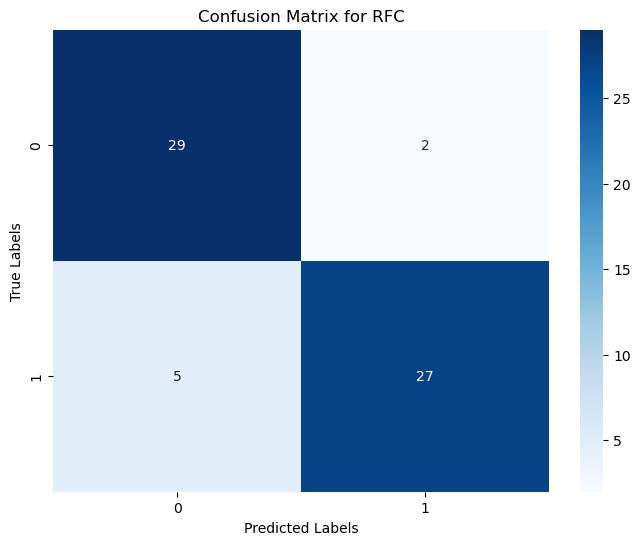

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: F

Best score for GBC: 0.876
Best parameters: {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 3, 'n_estimators': 100}
Test accuracy for GBC: 0.889
---------------------------------------------------------------


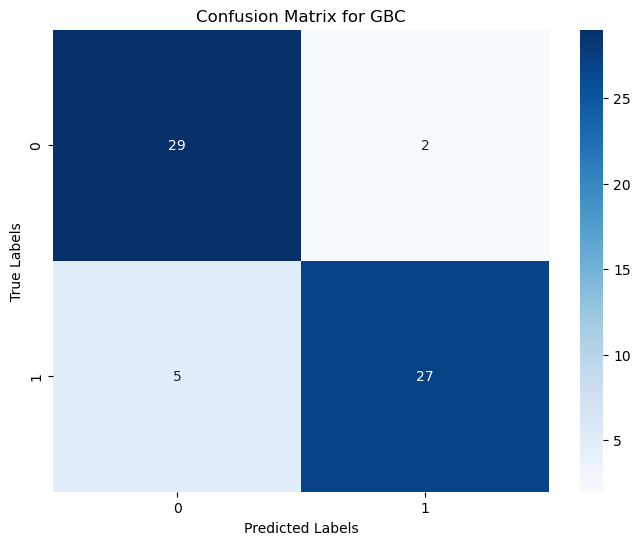

Best score for XGB: 0.876
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Test accuracy for XGB: 0.873
---------------------------------------------------------------


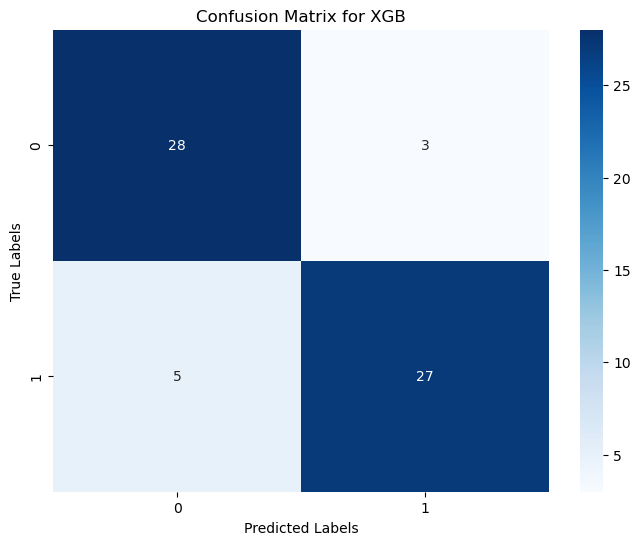

Best score for DTC: 0.856
Best parameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5}
Test accuracy for DTC: 0.825
---------------------------------------------------------------


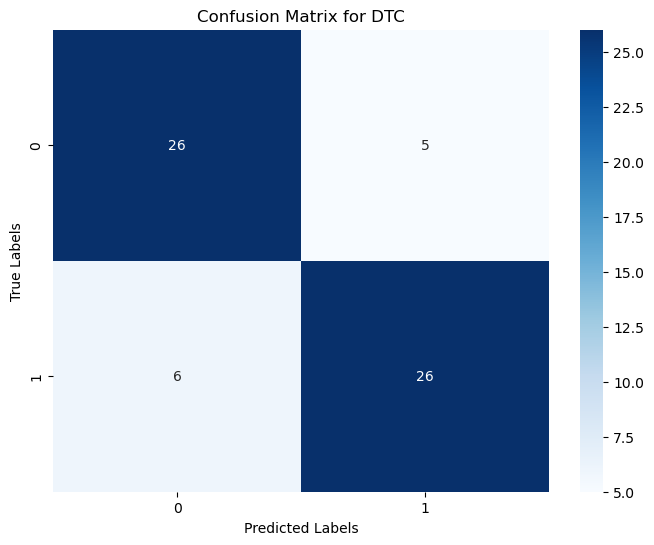

  Model  Best CV Score  Test Accuracy  \
0   RFC       0.855862       0.888889   
1   GBC       0.876322       0.888889   
2   XGB       0.876322       0.873016   
3   DTC       0.855632       0.825397   

                                     Best Parameters  
0  {'criterion': 'log_loss', 'max_depth': 20, 'mi...  
1  {'learning_rate': 0.01, 'loss': 'exponential',...  
2  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  
3  {'criterion': 'gini', 'max_depth': 30, 'min_sa...  


In [86]:
names = ["RFC", "GBC", "XGB", "DTC"]
models = get_selected_models(names)

param_grid = {
    'RFC': {
        "criterion":['gini', 'entropy', 'log_loss'],
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'GBC': {
        "loss":['log_loss', 'deviance', 'exponential'],
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGB': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    "DTC":{
        "criterion":['gini', 'entropy', 'log_loss'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }
}

metric = make_scorer(accuracy_score)

grid_search_selected_models(param_grid, names, models, X, y, metric)